# DM-Time Bowtie

By J. W. Kania

In [1]:
import numpy as np 
import cupy as cp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import math
from rich.progress import track
%matplotlib inline

In [2]:
height = 5*256 # height of plot
width = height # width of the plot, 8 heights + 2 heights pad 
dispersed = cp.zeros((height,width))# will hold noise + pulses
dispersed_top = cp.zeros((height,width))# will hold noise + incorrectly dedispersed pulse
dispersed_middle = cp.zeros((height,width))# will hold noise + correctly dedispered pulse
dispersed_bottom = cp.zeros((height,width))# will hold noise + incorrently dedispersed pulse
bow_tie = cp.zeros((height,width)) # will hold DM-Time bowtie
noise = cp.random.normal(size=[height,width])

In [3]:
def pulse(array, freq_bin, DM=0.004, offset=width/2, spacing=0, a=10, c=5):
    """
    Addes four quadratic pulses to an array, sweeps quadratically in frequency 
    
    Arguments:
    ---
    array: frequency chunck to add pulse to
    
    freq_bin: Frequency number to which pulse added
    
    Keyword Arguments:
    ---
    DM: the Dispersion Measure of the pulse
    
    offset: offset of first pulse from the left hand side
    
    spacing: spaces between the four pulses
    
    a: heigt of injected pulse
    
    c: width of injected pulse
    
    Returns: array with four guassian pulses
    """
    arg = cp.linspace(0,width, width)-offset # the x in the gussian 
    freq_bin+=64 # offset, the plot starts at a finite freq
    return array + a*(cp.exp(-(arg-DM*(freq_bin**2-64**2))**2/(2.*c**2))) # top channel is centered

In [4]:
DM = 0.00033 # The Dispersion Messure of the pulse
offset = width/2 # offset of the first pulse from the rhs
spacing = 0 # spaces between pulses - only want one pulse

In [5]:
for j, dm in enumerate(track(np.linspace(DM,-DM, height))):
    for fbin in range(0,height): # loop over noise array, injecting the pulses
        noise = cp.random.normal(size=[height,width]) # regenerate the noise every loop, else its correlated
        dispersed[fbin,:] = pulse(noise[fbin,:],fbin, DM=dm, offset=offset, spacing=spacing)# make a DM time plot
    bow_tie[j,:] = dispersed.mean(axis=0) # integrate over freq for each DM to get bowtie

Output()

# DM - Time Plot

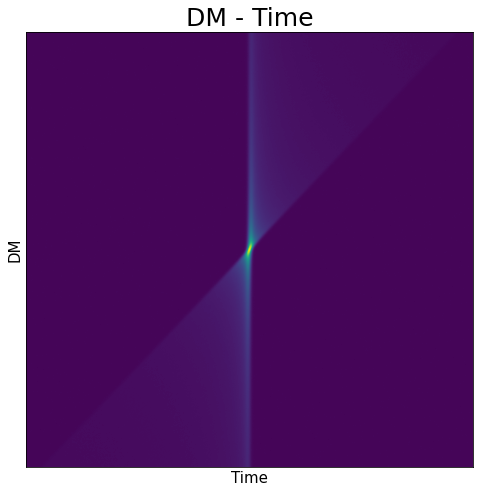

In [6]:
label_size = 15 # label font size 
fig, ax0 = plt.subplots(1,figsize=(8,8))
bow_time_img = plt.imshow(bow_tie.get(), aspect='auto')
clim_bowtie=bow_time_img.properties()['clim'] # set the levels for all the plots
plt.title('DM - Time',fontsize=25)
plt.xlabel('Time', fontsize=label_size)
plt.ylabel('DM', fontsize=label_size)

ax0.set_xticks([]) # kill axis ticks
ax0.set_yticks([])
plt.savefig('DM-Time_large.png', dpi=400)

# Lets Look at several slices of the DM-Time plot

## At center of DM-Time (Correct DM)

In [7]:
for fbin in range(0,height): #loop over noise array, injecting the pulse
    dispersed_middle[fbin,:] = pulse(noise[fbin,:],fbin, DM=0, offset=offset, spacing=spacing)

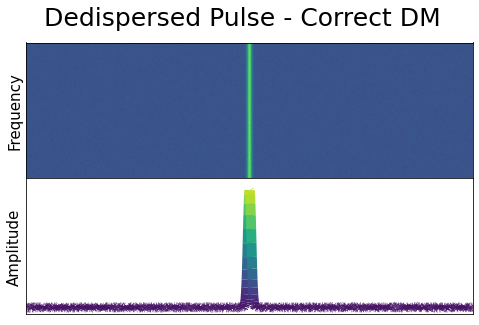

In [8]:
label_size = 15 # label font size 
fig, (ax0,ax1) = plt.subplots(2,figsize=(8,5), sharex=True)

fig.suptitle('Dedispersed Pulse - Correct DM',fontsize=25)
y = dispersed_middle.get().mean(axis=0)
min_value = np.min(y)-0.5
max_value = np.max(y)+1

# Freq-Time plot
disp_im = ax0.imshow(dispersed_middle.get(), aspect='auto')
ax0.set_ylabel('Frequency', fontsize=label_size)

# freq-time intergrated in freq->time series
ax1.set_ylim(min_value, max_value)
ax1.margins(x=0)
ax1.set_ylabel('Amplitude', fontsize=label_size)


# from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
points = np.array([np.linspace(0, width, width), y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(min_value, max_value)
lc = LineCollection(segments, norm=norm)
# Set the values used for colormapping
lc.set_array(y)
lc.set_linewidth(10)
line = ax1.add_collection(lc)
cb = fig.colorbar(line, ax=ax1, aspect="auto")
cb.remove() # remove the colro bar

# get rid of the ticks
for ax in (ax0,ax1):
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)

plt.savefig('Dedispersion_middle_large.png', dpi=400)

## At the top of the plot

In [9]:
for fbin in range(0,height): # loop over noise array, injecting the pulse
    dispersed_top[fbin,:] = pulse(noise[fbin,:],fbin, DM=DM, offset=offset, spacing=spacing)

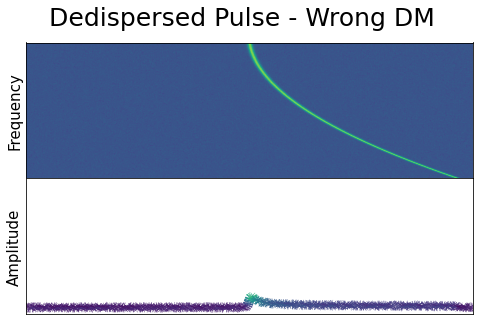

In [10]:
label_size = 15 # label font size 
fig, (ax0,ax1) = plt.subplots(2,figsize=(8,5),sharex=True)

fig.suptitle('Dedispersed Pulse - Wrong DM',fontsize=25)

# Freq-Time plot
disp_im = ax0.imshow(dispersed_top.get(), aspect='auto')
ax0.set_ylabel('Frequency', fontsize=label_size)

# freq-time intergrated in freq->time series
ax1.set_ylim(min_value, max_value)
ax1.margins(x=0)
ax1.set_ylabel('Amplitude', fontsize=label_size)

y = dispersed_top.get().mean(axis=0)

# from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
points = np.array([np.linspace(0, width, width), y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(bow_tie.min(), 0.15*bow_tie.max())
lc = LineCollection(segments, cmap='viridis', norm=norm,linestyle='--')
# Set the values used for colormapping
lc.set_array(y)
lc.set_linewidth(10)
line = ax1.add_collection(lc)
cb = fig.colorbar(line, ax=ax1, aspect="auto")
cb.remove() # remove the colro bar

# get rid of the ticks
for ax in (ax0,ax1):
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)

plt.savefig('Dedispersion_top_large.png', dpi=400)

## 3/4 down the DM-Time plot

In [11]:
for fbin in range(0,height): # loop over noise array, injecting the pulse
    dispersed_bottom[fbin,:] = pulse(noise[fbin,:],fbin, DM=-3*DM/4, offset=offset, spacing=spacing)

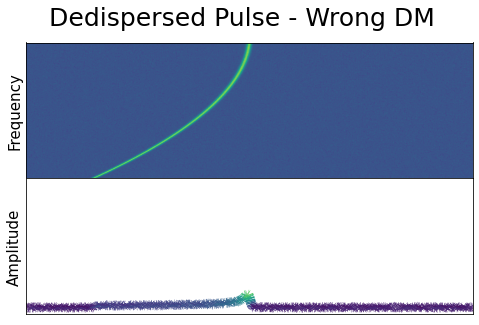

In [12]:
label_size = 15 # label font size 
fig, (ax0,ax1) = plt.subplots(2,figsize=(8,5), sharex=True)

fig.suptitle('Dedispersed Pulse - Wrong DM',fontsize=25)

# Freq-Time plot
disp_im = ax0.imshow(dispersed_bottom.get(), aspect='auto')
ax0.set_ylabel('Frequency', fontsize=label_size)

# freq-time intergrated in freq->time series
ax1.set_ylim(min_value, max_value)
ax1.margins(x=0)
ax1.set_ylabel('Amplitude', fontsize=label_size)

y = dispersed_bottom.get().mean(axis=0)

# from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
points = np.array([np.linspace(0, width, width), y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(bow_tie.min(), 0.15*bow_tie.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(y)
lc.set_linewidth(10)
line = ax1.add_collection(lc)
cb = fig.colorbar(line, ax=ax1, aspect="auto")
cb.remove() # remove the colro bar

# get rid of the ticks
for ax in (ax0,ax1):
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)

plt.savefig('Dedispersion_bottom_large.png', dpi=400)